In [1]:
## import libraries
import os, sys
import yaml
import xarray as xr
%matplotlib inline
path_to_repo = '/cw3e/mead/projects/cwp140/scratch/dnash/repos/SEAK_AR_impacts/'
sys.path.append(path_to_repo+'modules')
import GEFSv12_funcs as gefs

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [3]:
%%time

config_file = 'config_2.yaml' # this is the config file name
job_info = 'job_1' # this is the job name

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'

config = yaml.load(open(config_file), Loader=yaml.SafeLoader) # read the file
ddict = config[job_info] # pull the job info from the dict

year = ddict['year']
date = ddict['date']
ens = ddict['ens']
varname = 'ivt' ## can be 'ivt', 'freezing_level', or 'prec'

print('Preprocessing IVT ....')
varname_lst = ['ugrd', 'vgrd', 'spfh']
ds_lst = []
for i, varname in enumerate(varname_lst):
    ds = gefs.read_and_regrid_prs_var(varname, date, year)
    ds_lst.append(ds)

## load in surface pressure
print('Preprocessing surface pressure ....')
ds_pres = gefs.read_sfc_var('pres', date, year)
ds_lst.append(ds_pres)

ds = xr.merge(ds_lst) # merge u, v, and q into single ds
ds = ds.sel(isobaricInhPa=slice(300, 1000))
ds = ds.reindex(isobaricInhPa=ds.isobaricInhPa[::-1])
ds

Preprocessing IVT ....
Preprocessing surface pressure ....
CPU times: user 1min 4s, sys: 41.8 s, total: 1min 46s
Wall time: 1min 46s


<xarray.Dataset>
Dimensions:        (number: 3, step: 8, isobaricInhPa: 12, latitude: 281,
                    longitude: 479)
Coordinates:
  * number         (number) int64 0 1 2
  * step           (step) timedelta64[ns] 03:00:00 06:00:00 ... 1 days 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 400.0 300.0
  * latitude       (latitude) float64 70.0 69.75 69.5 69.25 ... 0.5 0.25 0.0
  * longitude      (longitude) float64 -179.5 -179.2 -179.0 ... -60.25 -60.0
    time           datetime64[ns] 2009-12-26
    valid_time     (step) datetime64[ns] 2009-12-26T03:00:00 ... 2009-12-27
    surface        float64 ...
Data variables:
    u              (number, step, isobaricInhPa, latitude, longitude) float64 ...
    v              (number, step, isobaricInhPa, latitude, longitude) float64 ...
    q              (number, step, isobaricInhPa, latitude, longitude) float64 ...
    sp             (number, step, latitude, longitude) float32 nan ... 9.915e+04
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-12-07T16:41 GRIB to CDM+CF via cfgrib-0.9.1...

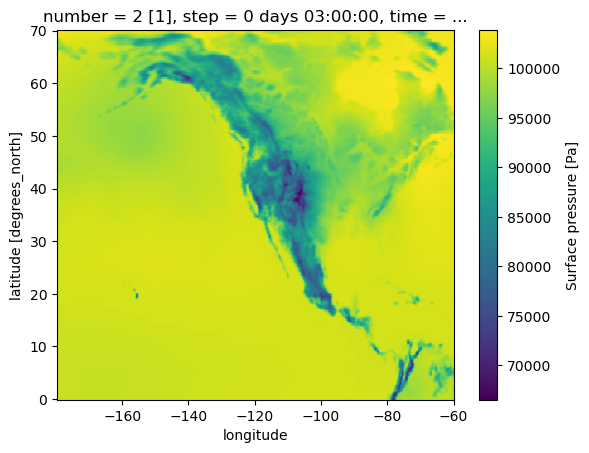

In [10]:
test = ds.sp.isel(step=0, number=2)
test.plot()

In [15]:
test = ds.sp.isel(step=0, number=2)
test = test.sel(latitude=37.5, longitude=-109.)
test/100.

<xarray.DataArray 'sp' ()>
array(814.74390625)
Coordinates:
    number      int64 2
    step        timedelta64[ns] 03:00:00
    latitude    float64 37.5
    longitude   float64 -109.0
    time        datetime64[ns] 2009-12-26
    valid_time  datetime64[ns] 2009-12-26T03:00:00
    surface     float64 ...

In [16]:
## is there data or nans at 1000 hpa
testq = ds.q.isel(step=0, number=2)
testq = testq.sel(latitude=37.5, longitude=-109.)
testq

<xarray.DataArray 'q' (isobaricInhPa: 12)>
array([2.71101692e-03, 2.52432167e-03, 2.33999989e-03, 2.15000007e-03,
       1.97000010e-03, 1.62999996e-03, 1.62000000e-03, 8.50000011e-04,
       2.80999986e-04, 1.32000001e-04, 3.60000013e-05, 7.99999998e-06])
Coordinates:
    number         int64 2
    step           timedelta64[ns] 03:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 400.0 300.0
    latitude       float64 37.5
    longitude      float64 -109.0
    time           datetime64[ns] 2009-12-26
    valid_time     datetime64[ns] 2009-12-26T03:00:00
    surface        float64 ...
Attributes: (12/30)
    GRIB_paramId:                             133
    GRIB_dataType:                            pf
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           q
    GRIB_totalNumber:                         10
    GRIB_units:                               kg kg**-1
    long_name:                                Specific humidity
    units:                                    kg kg**-1
    standard_name:                            specific_humidity

In [21]:
testq.where(testq.isobaricInhPa < test/100., drop=False)

<xarray.DataArray 'q' (isobaricInhPa: 12)>
array([           nan,            nan,            nan,            nan,
                  nan,            nan, 1.62000000e-03, 8.50000011e-04,
       2.80999986e-04, 1.32000001e-04, 3.60000013e-05, 7.99999998e-06])
Coordinates:
    number         int64 2
    step           timedelta64[ns] 03:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 400.0 300.0
    latitude       float64 37.5
    longitude      float64 -109.0
    time           datetime64[ns] 2009-12-26
    valid_time     datetime64[ns] 2009-12-26T03:00:00
    surface        float64 0.0
Attributes: (12/30)
    GRIB_paramId:                             133
    GRIB_dataType:                            pf
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           q
    GRIB_totalNumber:                         10
    GRIB_units:                               kg kg**-1
    long_name:                                Specific humidity
    units:                                    kg kg**-1
    standard_name:                            specific_humidity

In [29]:
import pandas as pd
from datetime import timedelta
import numpy as np
import yaml
from itertools import chain

## for each year between 2000 and 2019
date_lst = []
for i, yr in enumerate(range(2000, 2020)):
    ## get 55 days before November 21
    center_date = '{0}-11-21'.format(yr)
    center_date = pd.to_datetime(center_date)
    start_date = center_date - timedelta(days=55)
    
    ## get 45 days after November 21
    end_date = center_date + timedelta(days=45)

    ## make a list of dates between start_date and end_date
    dates = pd.date_range(start_date, end_date, freq='1D')
    
    date_lst.append(dates)
    
final_lst = np.concatenate(date_lst)

jobcounter = 0
filecounter = 0
## loop through to create dictionary for each job
d_lst = []
dest_lst = []
njob_lst = []
for i, date in enumerate(final_lst):
    jobcounter += 1
    t = pd.to_datetime(str(date)) 
    yr = t.strftime("%Y")
    dt = t.strftime("%Y%m%d")
    d = {'job_{0}'.format(jobcounter):
         {'year': yr,
          'date': dt,
          'ens': 'c00'
          }}
    d_lst.append(d)
    
    if (jobcounter == 999):
        filecounter += 1
        ## merge all the dictionaries to one
        dest = dict(chain.from_iterable(map(dict.items, d_lst)))
        njob_lst.append(len(d_lst))
        ## write to .yaml file and close
        file=open("config_{0}.yaml".format(str(filecounter)),"w")
        yaml.dump(dest,file, allow_unicode=True, default_flow_style=None)
        file.close()
        
        ## reset jobcounter and d_lst
        jobcounter = 0
        d_lst = []
        
## now save the final config
filecounter += 1
## merge all the dictionaries to one
dest = dict(chain.from_iterable(map(dict.items, d_lst)))
njob_lst.append(len(d_lst))
## write to .yaml file and close
file=open("config_{0}.yaml".format(str(filecounter)),"w")
yaml.dump(dest,file, allow_unicode=True, default_flow_style=None)
file.close()

## create calls.txt for config_1(-8)

for i, njobs in enumerate(njob_lst):
    call_str_lst = []
    for j, job in enumerate(range(1, njobs+1, 1)):
        call_string = "python getGEFSv12_batch.py config_{0}.yaml 'job_{1}'".format(i+1, j+1)
        call_str_lst.append(call_string)
        
    ## now write those lines to a text file
    with open('calls_{0}.txt'.format(i+1), 'w',encoding='utf-8') as f:
        for line in call_str_lst:
            f.write(line)
            f.write('\n')
        f.close()

In [ ]:
"""
Filename:    getGEFSv12_batch.py
Author:      Deanna Nash, dnash@ucsd.edu
Description: Download GEFSv12 Reforecast data based on input configuration dictionary.

"""
import sys
import yaml
import subprocess

### Imports config name from argument when submit
yaml_doc = sys.argv[1]
config_name = sys.argv[2]

# import configuration file for season dictionary choice
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ddict = config[config_name]

year = ddict['year']
date = ddict['date']
ens = ddict['ens']
varname = 'ivt' ## can be 'ivt', 'freezing_level', or 'prec'

## run download_GEFSv12_reforecast.sh to download data 
bash_script = "download_GEFSv12_reforecast.sh"
print(subprocess.run([bash_script, year, date, ens, varname]))